In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from bidi.algorithm import get_display
from pygooglenews import GoogleNews
import requests
import string
import emoji
import re
import datetime as dt
from textblob import TextBlob
from nltk.corpus import stopwords
from IPython.core.display import display, HTML

# plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('netanyahu_tweets.csv', sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7086 entries, 0 to 7085
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7086 non-null   int64  
 1   conversation_id  7086 non-null   int64  
 2   created_at       7086 non-null   object 
 3   date             7086 non-null   object 
 4   time             7086 non-null   object 
 5   timezone         7086 non-null   int64  
 6   user_id          7086 non-null   int64  
 7   username         7086 non-null   object 
 8   name             7086 non-null   object 
 9   place            0 non-null      float64
 10  tweet            7086 non-null   object 
 11  language         7086 non-null   object 
 12  mentions         7086 non-null   object 
 13  urls             7086 non-null   object 
 14  photos           7086 non-null   object 
 15  replies_count    7086 non-null   int64  
 16  retweets_count   7086 non-null   int64  
 17  likes_count   

In [4]:
# dropping columns according to NAN percentage threshold (keep all those columns with 70% Non-na values).
df.dropna(axis=1, thresh = int(0.7*df.shape[0]), inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7086 entries, 0 to 7085
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               7086 non-null   int64 
 1   conversation_id  7086 non-null   int64 
 2   created_at       7086 non-null   object
 3   date             7086 non-null   object
 4   time             7086 non-null   object
 5   timezone         7086 non-null   int64 
 6   user_id          7086 non-null   int64 
 7   username         7086 non-null   object
 8   name             7086 non-null   object
 9   tweet            7086 non-null   object
 10  language         7086 non-null   object
 11  mentions         7086 non-null   object
 12  urls             7086 non-null   object
 13  photos           7086 non-null   object
 14  replies_count    7086 non-null   int64 
 15  retweets_count   7086 non-null   int64 
 16  likes_count      7086 non-null   int64 
 17  hashtags         7086 non-null   

In [6]:
# converting columns (date,time) into datetime format.
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df.set_index(df['date'], inplace=True)
df = df.sort_index()

In [7]:
# number of tweets by language
df.language.value_counts()

iw     5100
en     1613
und     320
ro       12
in        9
hi        9
ar        9
fr        6
ru        2
tl        1
cs        1
hu        1
uk        1
pl        1
es        1
Name: language, dtype: int64

In [8]:
total_ndays = (df.date.max() - df.date.min()).days
print(f"Total number of days: {total_ndays}")
print(f"The average number of tweets sent per day: {round(len(df)/total_ndays,1)}")
print(f"Number of Hebrew tweets per day on average: {round(len(df[df.language == 'iw'])/total_ndays,1)}")
print(f"Number of English tweets per day on average: {round(len(df[df.language == 'en'])/total_ndays,1)}")

Total number of days: 4519
The average number of tweets sent per day: 1.6
Number of Hebrew tweets per day on average: 1.1
Number of English tweets per day on average: 0.4


#### Number of characters in a tweet

count    7086.0
mean      137.0
std        71.0
min         1.0
25%        84.0
50%       133.0
75%       174.0
max       312.0
Name: tweet_len, dtype: float64


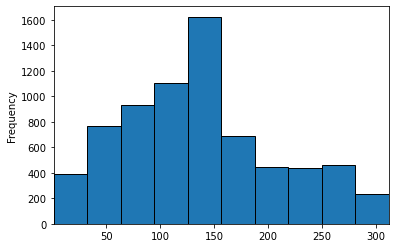

In [9]:
df['tweet_len'] = df['tweet'].map(lambda x: len(x))
print(df.tweet_len.describe().round())
df.tweet_len.plot(kind='hist',edgecolor="k");
plt.margins(x=0);

#### Likes, replies and retweets count statistics

In [10]:
def plot_counts_statistics(x):
    # To improve visualization and reflection of reality, outlairs were removed using np.clip.
    up_limit = df[x].mean() + df[x].std() * 4
    fig, ax = plt.subplots(figsize=(9,6))
    plt.hist(np.clip(df[x], 0, up_limit), bins=20,edgecolor="k")
    plt.axvline(df[x].median(), color='r');
    textstr = r'median=%.f' % (df[x].median().round())
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.75, 0.95, textstr, fontsize=14,transform=ax.transAxes,verticalalignment='top', bbox=props)
    plt.title(f'{x.capitalize()} distribution', size=15)
    plt.margins(x=0);    

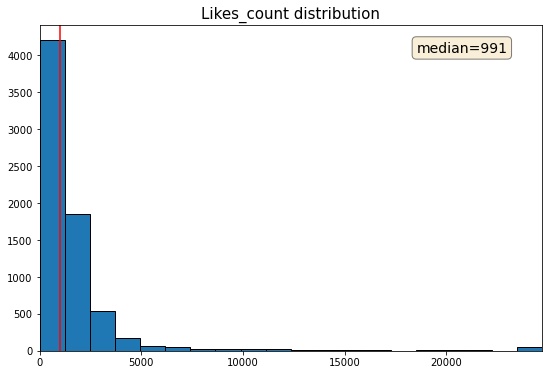

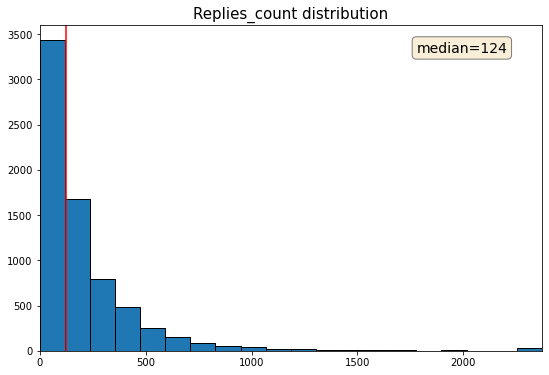

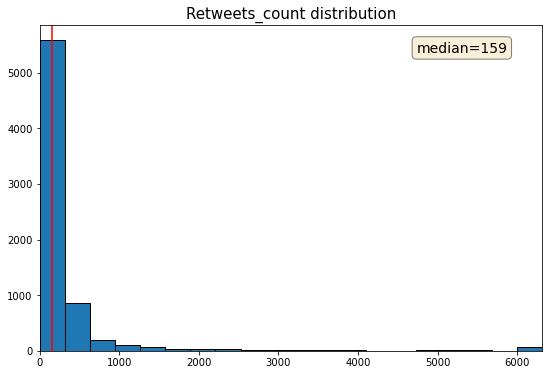

In [11]:
count_statitics= ['likes_count', 'replies_count', 'retweets_count']
for i in count_statitics:
    plot_counts_statistics(i)

In [12]:
def plot_targeted_feature(x, y):
    
    up_limit = df[y].mean() + df[y].std() * 4
    fig, ax = plt.subplots(figsize=(7,5))
    if x =='video':
        x1 = df[df[x] ==0][y]
        x2 = df[df[x] ==1][y]
    else:
        x1 = df[df[x] =="[]"][y]
        x2 = df[df[x] !="[]"][y]
    plt.hist(np.clip(x1, 0, up_limit), color='gray',bins=50, alpha=0.7, label=f'without {x}')
    plt.hist(np.clip(x2, 0, up_limit), color='red',bins=50, alpha=0.7, label=f'with {x}')
    plt.axvline(x1.median(), color='gray');
    plt.axvline(x2.median(), color='red');
    plt.title(f'Tweets with {x.capitalize()} - likes count distribution', size=15)
    plt.margins(x=0); plt.legend();

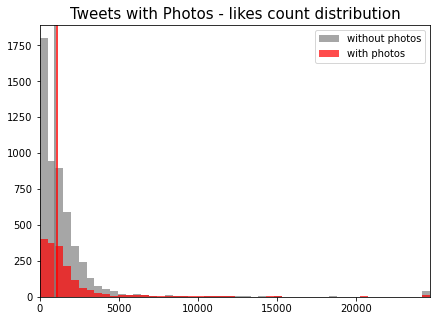

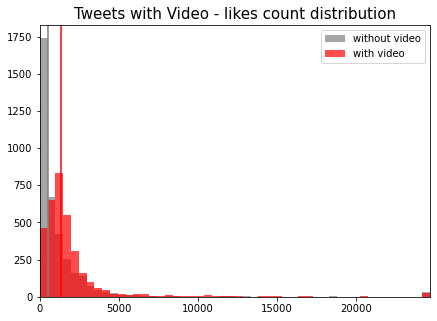

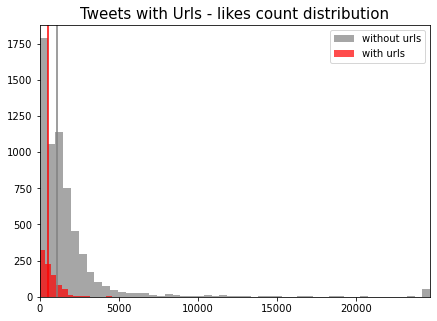

In [13]:
count_statitics2= ['photos', 'video', 'urls']
for i in count_statitics2:
    plot_targeted_feature(i,'likes_count')

####  <font color='grey'> When a video is added to a tweet, the number of likes increases, when an image is added, the number of likes stays the same, and when a URL included, the number of likes falls below the norm. </font>

## Hebrew tweets

In [14]:
df = df[df.language =='iw']

### Tweets by time of the day

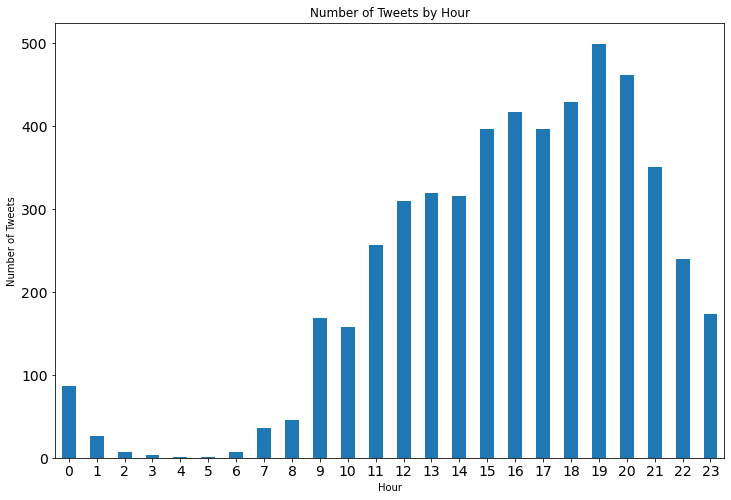

In [15]:
title = 'Number of Tweets by Hour'
df.tweet.groupby(df.time.dt.hour).count().plot(figsize=(12,8), fontsize=14, kind='bar', rot=0, title=title)
plt.xlabel('Hour')
plt.ylabel('Number of Tweets');

### Tweets by day of the week

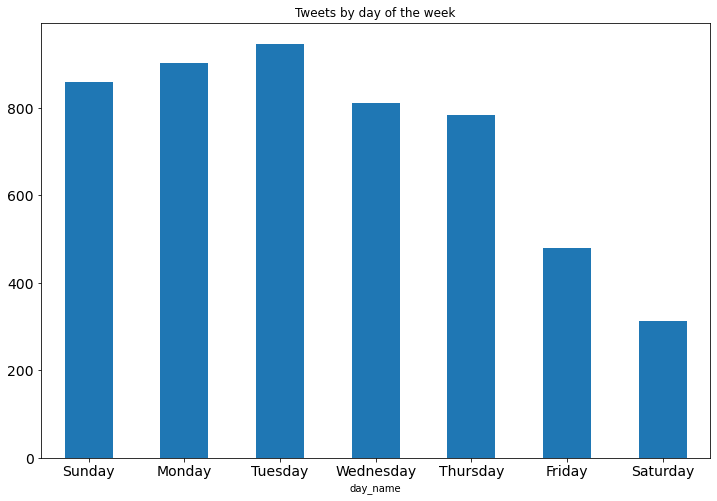

In [16]:
df['day_name'] = df["date"].dt.day_name()
cats= ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df_weekday = df.tweet.groupby(df['day_name']).count().reindex(cats)
title = 'Tweets by day of the week'
df_weekday.plot(figsize=(12,8), fontsize=14, kind='bar', rot=0, title=title);
# plt.xlabel('Hour')
# plt.ylabel('Number of Tweets');

#### Most liked tweets

In [17]:
pd.set_option('display.max_colwidth', None)
likesorder=df[['likes_count','tweet']].sort_values(by=['likes_count'],ascending=False)
likesorder.head(10)

,likes_count,tweet
date,,
2019-05-23,64690,"ברכות מקרב לב לך, ידידי @Narendramodi, על ניצחונך המרשים בבחירות! תוצאות הבחירות הן אישור נוסף למנהיגותך ולדרך בה אתה מוביל את הדמוקרטיה הגדולה בעולם. יחד נמשיך לחזק את הידידות הגדולה בינינו ובין הודו וישראל ולהובילה לפסגות חדשות. כל הכבוד, ידידי! 🇮🇱👐🇮🇳"
2019-05-23,37854,מזל טוב ידידי נרנדרה מודי! @narendramodi https://t.co/72O2i0MtIa
2019-04-10,37437,תודה ♥️ https://t.co/nucHw9ng0R
2020-01-29,33858,"היום לפני 28 שנים, ישראל והודו כוננו יחסים דיפלומטיים רשמיים. אני מברך את ידידי נרנדרה מודי על החברות החמה שלו. בין ישראל להודו נוצרה חברות עמוקה שניכרת בשיתופי הפעולה הרבים שלנו. נמשיך לחזק את החברות החשובה הזו. 🇮🇱🇮🇳 https://t.co/SUBR4R2MP2"
2019-07-28,28317,נתניהו. ליגה אחרת. https://t.co/07YGtjfXwL
2018-12-29,20078,"אחרי רצף פגישות מדיניות מוצלחות מאוד בברזיל, יצאנו לפגוש את העם ברחוב. אהבה אדירה למדינת ישראל! 🇮🇱 🇧🇷 https://t.co/mqczK3FH9p"
2017-05-23,19262,"חבר אמת A true friend 🇮🇱🇺🇸 @realDonaldTrump (צילום: אבי אוחיון, לע״מ) https://t.co/7g53JGvPfC"
2018-11-01,18430,"מברך את ידידי נשיא ברזיל הנכנס, ז'איר בולסונארו, על כוונתו להעביר את שגרירות ברזיל לירושלים. זהו צעד היסטורי, נכון ומרגש!"
2020-10-06,16972,תמונה מרגשת מדובאי -- שלום תמורת שלום יוצר חברים חדשים במזרח התיכון. 🇮🇱🇦🇪 https://t.co/hzuaWemp3I


#### Visualize the most liked tweet

In [18]:
def show_tweet(link):
    url = f'https://publish.twitter.com/oembed?url={link}'
    response = requests.get(url)
    html = response.json()['html']
    display(HTML(html))
    
most_liked_tweet = df[df.likes_count == max(df.likes_count)]['link'].values[0]
show_tweet(most_liked_tweet)

### Average number of tweets/retweets/likes (Hebrew) vs. election days, time series review

In [19]:
# calculating election dates and the date, 90 days before the elections
election_dates = ['2015-03-17', '2019-04-09', '2019-09-17', '2020-03-02']
four_month_bfore_election = []
for i in election_dates:
    four_month_bfore_election.append(str(dt.datetime.fromisoformat(i).date() - dt.timedelta(days=90)))

time_range_b4_elections = list(zip(four_month_bfore_election,election_dates))   
time_range_b4_elections

[('2014-12-17', '2015-03-17'),
 ('2019-01-09', '2019-04-09'),
 ('2019-06-19', '2019-09-17'),
 ('2019-12-03', '2020-03-02')]

The average number of tweets per month in the three months preceding the election of 2015-03-17:  81
The average number of tweets per month in the three months preceding the election of 2019-04-09:  121
The average number of tweets per month in the three months preceding the election of 2019-09-17:  130
The average number of tweets per month in the three months preceding the election of 2020-03-02:  136

When there is no election on the horizon (2015-04 -> 2018-12), the average number of tweets per month is: 32


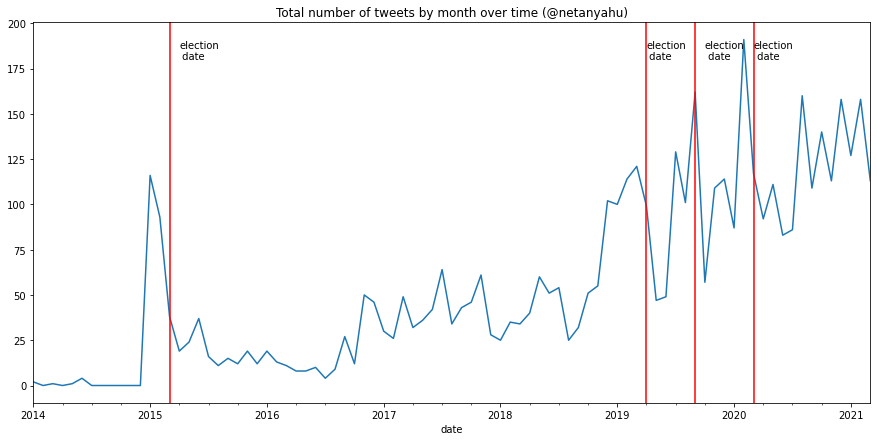

In [20]:
# calculating and plotting tweets by time series vs election dates, and 3 preceding months agg average number of tweets 

df['2014':].resample('M')['id'].count().plot(figsize=(15,7),y="");
plt.title("Total number of tweets by month over time (@netanyahu)");
for d in election_dates:
    plt.axvline(dt.datetime.fromisoformat(d), color='r')
    plt.text(dt.datetime.fromisoformat(d)+dt.timedelta(20),180,f'election\n date')
for i in time_range_b4_elections:
    print(f"The average number of tweets per month in the three months preceding the election of {i[1]}: "\
          ,round(df[i[0]:i[1]].tweet.count()/3))
print()
print('When there is no election on the horizon (2015-04 -> 2018-12), the average number of tweets per month is:',
      round(df['2015-04':'2018-12-31'].groupby(pd.Grouper(freq='M'))['id'].count().mean()))

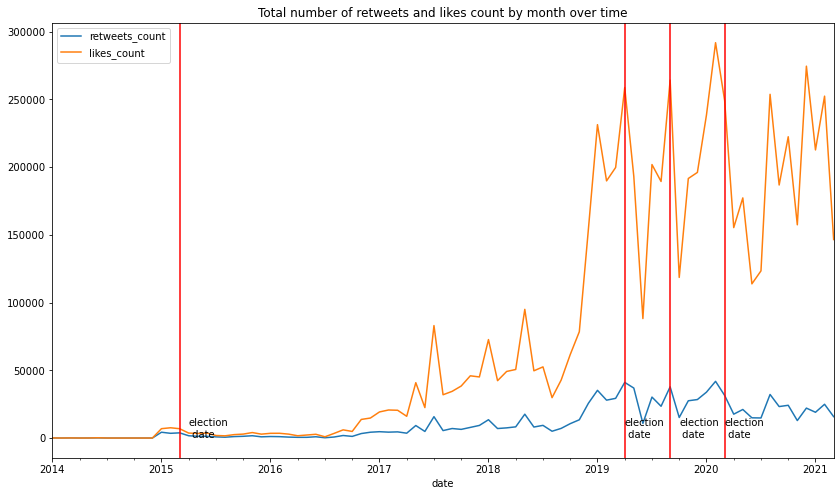

In [21]:
df['2014':].resample('M')[['retweets_count','likes_count']].sum().plot(figsize=(14,8));
plt.title("Total number of retweets and likes count by month over time");
for d in election_dates:
    plt.axvline(dt.datetime.fromisoformat(d), color='r')
    plt.text(dt.datetime.fromisoformat(d)+dt.timedelta(20),180,f'election\n date')

### Correlation between retweets and likes 

In [22]:
df['2014':].resample('M')[['retweets_count','likes_count']].sum().corr()

,retweets_count,likes_count
retweets_count,1.000000,0.962704
likes_count,0.962704,1.000000


#### Taking the top dates with the most tweets and comparing them to election dates.

In [23]:
# Top dates with the highest number of tweets
df.date.value_counts().head()

2015-01-05    26
2019-09-17    26
2015-01-11    21
2019-04-09    19
2020-03-02    17
Name: date, dtype: int64

In [24]:
for i in df.date.value_counts().head().index.strftime('%Y-%m-%d').tolist():
    if i in election_dates:
        print(i)

2019-09-17
2019-04-09
2020-03-02


#### As can be shown, three of the four election days are also among the top tweeting dates.

#### * I wrote a function that uses GoogleNews to investigate what happened in the news in order to explain the other dates (not election days) that in the top tweeting days.

In [25]:
def news_headline(date):
    
    gn = GoogleNews(country="Israel", lang="he")
    search = gn.search("נתניהו",from_=date, to_=str(dt.datetime.fromisoformat(date) + pd.Timedelta(days=1)))
    newsitem = search['entries']
    for i in newsitem[:5]:
        print(i.title)
        
for i in df.date.value_counts().head().index.strftime('%Y-%m-%d').tolist():
    if i not in election_dates:
        print(f'News for {i}:')
        print(news_headline(i))

News for 2015-01-05:
נתניהו משיק קמפיין הליכוד: מציע חוק משילות חדש ותוקף את השמאל - וואלה! בחירות 2021 - וואלה!
סקר: נתניהו עדיין מוביל, הרצוג ולבני נשארים צמודים - וואלה! בחירות 2021 - וואלה!
דיור, יוקר המחיה, גיוס לכולם ושיטת הממשל: הבטחות נתניהו שלא מומשו - ynet ידיעות אחרונות
חוק המשילות של נתניהו: ראש המפלגה הגדולה - אוטומטית ראש ממשלה - ynet ידיעות אחרונות
זה ראש הממשלה נתניהו או המלך הורדוס? - ynet ידיעות אחרונות
None
News for 2015-01-11:
"בצרפת אמרו: עדיף שנתניהו לא יגיע" - ynet ידיעות אחרונות
בחירות 2015: מי הפוליטיקאי הכי פופולרי ברשת? - גלובס
נתניהו ליהודי צרפת: "תתקבלו כאן בלב חם" - כל הזמן
עצרת מיליונים בפריז: אחדות נגד הטרור - ynet ידיעות אחרונות
האם מד הטמפרטורה ברכב מדייק? - The Marker
None


### Tweet text preprocessing

In [26]:
def remove_pe(text):
    "remove punctuation and emojis"
    text_without = "".join([c for c in text if c not in string.punctuation])
    text_without_pe =  emoji.get_emoji_regexp().sub(r'', text_without)
    return text_without_pe

def removeWeirdChars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weridPatterns.sub(r'', text)

In [27]:
# clean the text from punctuation, emojis, numbers, urls
df['clean_tweet'] = df['tweet'].apply(lambda x: remove_pe(x)).apply(lambda x: re.sub(r'[A-Za-z]|http\S+|[0-9]+', '',x))\
                     .apply(lambda x: removeWeirdChars(x))

In [28]:
# example of the clean tweets 
df[["clean_tweet"]].tail(5)

,clean_tweet
date,
2021-03-14,לפיד מסתתר מאחורי גדעון ובנט כדי שלא תדעו שאין להם ממשלה בלעדיו אבל זו האמת רק הליכוד יכול להקים ממשלת ימין יציבה בלי רוטציה ובלי לפיד כדי להזניק את הכלכלה שלנו אחרי הקורונה
2021-03-14,יאללה בית״ר שידור חי מטדי חוזרים לחיים
2021-03-14,יאללה בית״ר חוזרים לחיים חוזרים למגרשים
2021-03-15,קודם החיסונים עכשיו הכלכלה
2021-03-15,נפתלי בנט תתחייב לממשלה בלי יאיר לפיד בממשלה ובלי רוטציה


In [29]:
# importing text file with Hebrew stoop words
with open('he_stop_words.txt', "r") as f:
    he_s_words = f.readline()

In [30]:
he_s_words

"['אני', 'את', 'אתה', 'אנחנו', 'אתן', 'אתם', 'הם', 'הן', 'היא', 'הוא', 'שלי', 'שלו', 'שלך', 'שלה', 'שלנו', 'שלכם', 'שלכן', 'שלהם', 'שלהן', 'לי', 'לו', 'לה', 'לנו', 'לכם', 'לכן', 'להם', 'להן', 'אותה', 'אותו', 'זה', 'זאת', 'אלה', 'אלו', 'תחת', 'מתחת', 'מעל', 'בין', 'עם', 'עד', 'נגר', 'על', 'אל', 'מול', 'של', 'אצל', 'כמו', 'אחר', 'אותו', 'בלי', 'לפני', 'אחרי', 'מאחורי', 'עלי', 'עליו', 'עליה', 'עליך', 'עלינו', 'עליכם', 'לעיכן', 'עליהם', 'עליהן', 'כל', 'כולם', 'כולן', 'כך', 'ככה', 'כזה', 'זה', 'זות', 'אותי', 'אותה', 'אותם', 'אותך', 'אותו', 'אותן', 'אותנו', 'ואת', 'את', 'אתכם', 'אתכן', 'איתי', 'איתו', 'איתך', 'איתה', 'איתם', 'איתן', 'איתנו', 'איתכם', 'איתכן', 'יהיה', 'תהיה', 'היתי', 'היתה', 'היה', 'להיות', 'עצמי', 'עצמו', 'עצמה', 'עצמם', 'עצמן', 'עצמנו', 'עצמהם', 'עצמהן', 'מי', 'מה', 'איפה', 'היכן', 'במקום שבו', 'אם', 'לאן', 'למקום שבו', 'מקום בו', 'איזה', 'מהיכן', 'איך', 'כיצד', 'באיזו מידה', 'מתי', 'בשעה ש', 'כאשר', 'כש', 'למרות', 'לפני', 'אחרי', 'מאיזו סיבה', 'הסיבה שבגללה', 'למה', 'מדוע'

In [31]:
# Making tweets into one big list and putting out the stop words
temp = " ".join(df['clean_tweet'].tolist())
temp = " ".join([i for i in temp.split() if i not in he_s_words]) 

In [32]:
temp[:200]

'בערב כנסים ברמלה ובגבעתים נכנס עכשיו למסיבת עיתונאים מירי רגב מצטרפת חדשה לליכוד בישיבת סיעה בכנסת העלינו עמוד תומכים בפייסבוק עובדים במרץ אתר חדש דן מרידור יודיע הבוקר חזרתו למפלגת הליכוד המכתב נתניה'

### Word Cloud 
#### (Text data visualization. It shows a list of words with varying sizes to reflect their significance).

In [33]:
wordcloud = WordCloud(width=800, height=500,
                      font_path = 'C:\Windows\Fonts\courbd.ttf',
                      background_color='white',
                      min_font_size= 10).generate(get_display(temp))

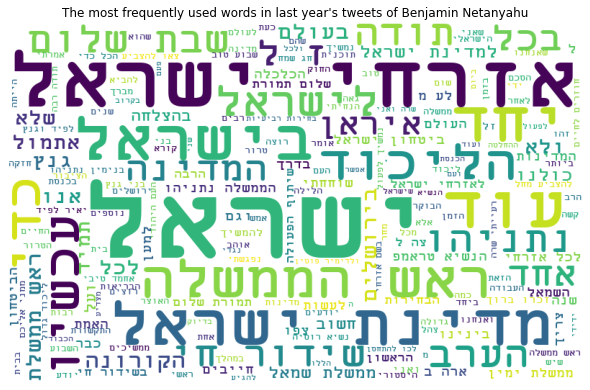

In [34]:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0);
plt.title("The most frequently used words in last year's tweets of Benjamin Netanyahu", size=12);

#### There seems to be a problem with applying Hebrew-stop words. As we see in the words presentation, the same term appears several times because the stopwords are prefix connected with the term itself. In this example 'and'/'in'/'the'/'as'/'like'..etc.. 

In [35]:
from googletrans import Translator

#### taking the last year tweets (365 days) and translate them from Hebrew to English

In [36]:
def translate(text):
    
    translator = Translator()
    result = translator.translate(text,dest='en')
    return result.text

In [37]:
# new data frame of the last 365 days
df_with_trans = df.tail(365).copy()

In [38]:
%%time

df_with_trans = df.tail(365).copy()
df_with_trans['he_trans'] = df_with_trans['clean_tweet'].apply(lambda x: translate(x))

Wall time: 2min 49s


#### Tweet translation examples from Hebrew to English

In [39]:
df_with_trans[['clean_tweet','he_trans']].sample(5)

,clean_tweet,he_trans
date,,
2021-02-24,אנחנו חייבים לעבור את פורים בשלום כדי שאת פסח נחגוג יחד הצגתי הערב את תוכנית שלבי היציאה שלנו מהקורונה,We must pass Purim in peace so that Pesach is celebrated together I presented the plan of our exit from the original
2021-03-11,ראש ממשלת הונגריה ויקטור אורבן ״המנהיגות של נתניהו הביאה את ישראל להצלחה עולמית נגד הקורונה״,"Hungarian Prime Minister Victor Urban ""Netanyahu's leadership brought Israel to global success against the corona"""
2021-02-27,אבל זה הכל תלוי בכם שימרו על הכללים אני מבקש מכם למען החיים שלכם ושל היקרים לכם שבוע טוב,But it all depends on you preserved on the rules I ask you for your life and the dear you a good week
2021-01-19,אני קורא לכל אזרחי ישראל גם אלה שהשתתפו אתמול בחתונה השערורייתית בבני ברק להפסיק להפר את החוק זו שפיכות דמים אני מצפה מהמשטרה לנקוט יד ברזל נגד כל מפירי החוק באשר הם,I call all Israeli citizens who have participated yesterday at the scandalous wedding in Bnei Brak to stop violating this bloodshed law I expect the police to take an iron hand against all the firles of the law.
2021-02-17,הקשיבו לפרופ ערן סגל ממכון ויצמן הסיכוי לתחלואה קשה בגיל הוא גבוה מאוד לכו להתחסן,Listen to Professor Eran Segal from the Weizmann Institute The chance of hard morbidity at the age is very high to coming to vaccinations


In [40]:
# Making tweets into one big list and putting out the stop words
temp1 = " ".join(df_with_trans['he_trans'].tolist())
temp1 = " ".join([i for i in temp1.split() if i not in stopwords.words('english')]) 

In [41]:
wordcloud = WordCloud(width=800, height=500,
                      background_color='white',
                      min_font_size= 10).generate(temp1)

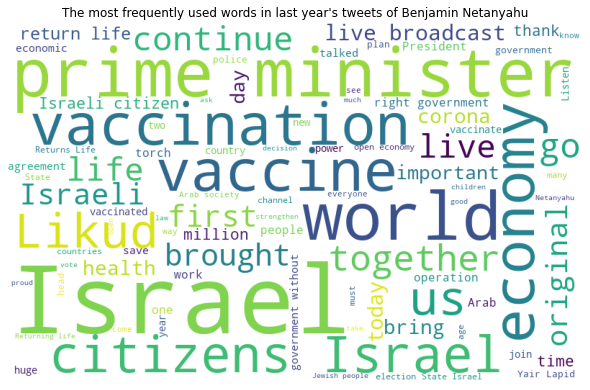

In [42]:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0);
plt.title("The most frequently used words in last year's tweets of Benjamin Netanyahu", size=12);

### Named-entity recognition (NER)
#### Lets see how Spacy handle information extraction that seeks to locate and classify named entities mentioned in our tweets text into pre-defined categories such as person names, organizations, locations, time expressions etc.

In [43]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [44]:
ent = nlp(temp1)

In [45]:
df_ent = pd.DataFrame([(X.text, X.label_) for X in ent.ents], columns = ['Word','Entity'])

#### Organizations

In [46]:
df_ent.where(df_ent['Entity'] == 'ORG').value_counts().head()

Word          Entity
Likud         ORG       28
State         ORG       10
Torch         ORG        4
Yair Lapid    ORG        3
Beit Shemesh  ORG        2
dtype: int64

#### Persons

In [47]:
df_ent.where(df_ent['Entity'] == 'PERSON').value_counts().head()

Word            Entity
Netanyahu       PERSON    10
Gideon Bennett  PERSON     5
Shabbat Shalom  PERSON     5
Sarah           PERSON     4
Yair Lapid      PERSON     4
dtype: int64

#### Geo-Political Entity

In [48]:
df_ent.where(df_ent['Entity'] == 'GPE').value_counts().head()

Word       Entity
Israel     GPE       121
Korona     GPE         6
Jerusalem  GPE         6
Iran       GPE         6
Corah      GPE         5
dtype: int64

#### Nationalities or religious or political groups

In [49]:
df_ent.where(df_ent['Entity'] == 'NORP').value_counts().head()

Word      Entity
Israeli   NORP      34
Arab      NORP      28
Jewish    NORP       8
Israelis  NORP       5
Iranian   NORP       3
dtype: int64

#### Date

In [50]:
df_ent.where(df_ent['Entity'] == 'DATE').value_counts().head()

Word       Entity
today      DATE      17
yesterday  DATE       6
Today      DATE       3
years      DATE       3
two weeks  DATE       3
dtype: int64

#### Cardinal (numbers that do not fit into another category)

In [51]:
df_ent.where(df_ent['Entity'] == 'CARDINAL').value_counts().head()

Word       Entity  
one        CARDINAL    10
two        CARDINAL     8
millions   CARDINAL     6
million    CARDINAL     5
A million  CARDINAL     3
dtype: int64

#### Time

In [52]:
df_ent.where(df_ent['Entity'] == 'TIME').value_counts().head()

Word          Entity
evening       TIME      2
morning       TIME      2
tonight       TIME      2
As morning    TIME      1
Good evening  TIME      1
dtype: int64

#### Events

In [53]:
df_ent.where(df_ent['Entity'] == 'EVENT').value_counts().head()

Word                          Entity
Operation "Returns Life       EVENT     1
Operation "Returns Life" All  EVENT     1
The Golan Heights Galilee     EVENT     1
dtype: int64

### NER conclusion: Not perfect, to say the least. There are a number of errors in identification, most of them in the Organization and Person entities

### Sentiment Analysis

In [54]:
df_with_trans['sentiment'] = df_with_trans['he_trans'].apply(lambda x:TextBlob(x).sentiment[0])
df_with_trans['polarity'] = df_with_trans['sentiment'].apply(lambda x: 'pos' if x>=0 else 'neg')

Positive & Negative (%)
pos    88.77
neg    11.23
Name: polarity, dtype: float64


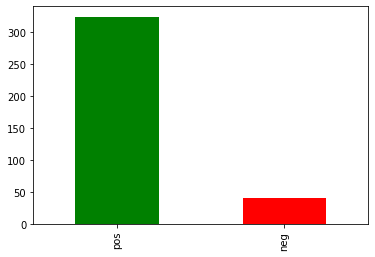

In [55]:
df_with_trans['polarity'].value_counts().plot(kind='bar', color=['g','r']);
print('Positive & Negative (%)')
print(round(df_with_trans['polarity'].value_counts(normalize=True)*100,2))

In [56]:
df_with_trans.loc[df_with_trans['sentiment']>0].nlargest(3,'sentiment')[['clean_tweet']]

,clean_tweet
date,
2021-02-08,פגישה מצויינת היום עם ידידי ראש ממשלת יוון קיריאקוס מיצוטאקיס קידמנו את היחסים בינינו בכל התחומים סחר ביטחון ושיתוף הפעולה הטכנולוגי סגרנו על ״דרכון ירוק״ שיאפשר לישראלים לטוס ליוון בלי מגבלות אחרי שנפתח את השמיים נמשיך להביא את היחסים בינינו לשיאים חדשים
2021-02-19,ביקרתי היום בדוכן פלאפל מעולה באור עקיבא אנחנו רוצים לדאוג לבעלי העסקים לעצמאים ולשולמנים וזו שערוריה שפוליטיקאים ויועצים משפטיים חסרי אחריות מנסים למנוע זאת מאיתנו אבל כפי שהבאנו את ישראל למקום הראשון בעולם בחיסונים כך נזניק את הכלכלה שלנו בשנה הקרובה לשיאים חדשים
2021-02-23,שמחתי מאוד לבקר במאפייה בקריית שמונה יחד חוזרים לחיים


In [57]:
df_with_trans.loc[df_with_trans['sentiment']<0].nsmallest(3,'sentiment')[['clean_tweet']]

,clean_tweet
date,
2021-01-22,אני מגנה בכל תוקף את האלימות כלפי כוחות משטרת ישראל שפעלו בבני ברק ומחזק את ידי גורמי האכיפה שדואגים לשמור על תקנות משרד הבריאות שמצילות חיים אנו נפעל ביד קשה נגד מפרי החוק בראש ובראשונה נגד מי שהרים את ידו נגד השוטרות והשוטרים שלנו
2021-03-03,מי אמר שאין מילה טובה בערוץ תודה עדן
2021-01-19,מצד אחד כספית הלך למשטרת ישראל פעם אחר פעם כדי לתפור את התיקים האבסורדיים נגד רה״מ ומצד השני כ״עיתונאי אובייקטיבי״ כביכול הוא פירסם את טענותיו המומצאות בתקשורת כאילו הגיעו ממקורות אחרים כדי להפעיל לחץ על המשטרה והיועמ״ש להמשך מסע הצייד נגד רה״מ
